In [1]:
import pandas as pd
import os

In [2]:
os.chdir("/Users/sarathsabu/Desktop/scma/A2")

In [3]:
ipl_bbb = pd.read_csv('IPL_ball_by_ball_updated till 2024.csv',low_memory=False)

In [4]:
grouped_data = ipl_bbb.groupby(['Season', 'Innings No', 'Striker','Bowler']).agg({'runs_scored': sum, 'wicket_confirmation':sum}).reset_index()

In [5]:
player_runs = grouped_data.groupby(['Season', 'Striker'])['runs_scored'].sum().reset_index()
player_wickets = grouped_data.groupby(['Season', 'Bowler'])['wicket_confirmation'].sum().reset_index()

## a) NSSO68 Data Multiple Regression

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set working directory and load the dataset
data = pd.read_csv('NSSO68.csv',low_memory=False)

# Display unique values in 'state_1' column
print(data['state_1'].unique())

# Subset data for state 'KA'
subset_data = data[data['state_1'] == 'KA'][['foodtotal_q', 'MPCE_MRP', 'MPCE_URP', 'Age', 'Meals_At_Home', 'Possess_ration_card', 'Education', 'No_of_Meals_per_day']]

# Print subset data
print(subset_data)

# Check for missing values
print(subset_data['MPCE_MRP'].isna().sum())
print(subset_data['MPCE_URP'].isna().sum())
print(subset_data['Age'].isna().sum())
print(subset_data['Possess_ration_card'].isna().sum())
print(data['Education'].isna().sum())

['GUJ' 'ORI' 'CHTSD' 'MP' 'JRKD' 'WB' 'AP' 'MH' 'D&D' 'D&NH' 'MIZ' 'TRPR'
 'MANPR' 'ASSM' 'MEG' 'NAG' 'A&N' 'PNDCRY' 'TN' 'GOA' 'KA' 'KE' 'LKSDP'
 'SKM' 'Bhr' 'UP' 'RJ' 'ARP' 'DL' 'HR' 'Pun' 'HP' 'UT' 'Chandr' 'J$K']
       foodtotal_q  MPCE_MRP  MPCE_URP  Age  Meals_At_Home  \
23109    17.925351   1124.92    982.00   38           54.0   
23110    25.517352   2336.88   1704.67   45           30.0   
23111    25.470640   1660.76   1243.80   88           60.0   
23112    29.984010   2457.52   1853.00   63           60.0   
23113    17.760602   1334.57   1221.80   33           58.0   
...            ...       ...       ...  ...            ...   
64086    16.200258    789.43    738.33   46           90.0   
64087    24.787846   1589.75   1250.50   58           90.0   
64088    15.100283    848.95    719.50   37           90.0   
64089    16.175296    824.82    766.88   40           90.0   
64090    23.075418   1370.72   1212.50   30           90.0   

       Possess_ration_card  Education 

In [7]:
# Function to impute missing values with mean
def impute_with_mean(df, columns):
    for col in columns:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

# Columns to impute
columns_to_impute = ['Education', 'MPCE_MRP', 'MPCE_URP', 'Age', 'Meals_At_Home', 'Possess_ration_card']

# Impute missing values with mean in the subset data
subset_data = impute_with_mean(subset_data, columns_to_impute)

# Ensure no infinite values
subset_data = subset_data.replace([np.inf, -np.inf], np.nan)

# Drop rows with any remaining NaN values
subset_data.dropna(inplace=True)

In [8]:
# Fit the regression model
X = subset_data[['MPCE_MRP', 'MPCE_URP', 'Age', 'Meals_At_Home', 'Possess_ration_card', 'Education']]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = subset_data['foodtotal_q']
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            foodtotal_q   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     140.6
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          1.66e-162
Time:                        21:36:58   Log-Likelihood:                -14354.
No. Observations:                4094   AIC:                         2.872e+04
Df Residuals:                    4087   BIC:                         2.877e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.0534    

In [9]:
# Check for multicollinearity using Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)  # VIF value more than 8 is problematic

# Extract the coefficients from the model
coefficients = model.params

               feature        VIF
0                const  47.066548
1             MPCE_MRP   1.681909
2             MPCE_URP   1.512695
3                  Age   1.117918
4        Meals_At_Home   1.107049
5  Possess_ration_card   1.171771
6            Education   1.222947


In [10]:
# Construct the equation
equation = f"y = {round(coefficients[0], 2)}"
for i in range(1, len(coefficients)):
    equation += f" + {round(coefficients[i], 6)}*x{i}"
print(equation)

# Display the first values of selected columns
print(subset_data['MPCE_MRP'].head(1).values[0])
print(subset_data['MPCE_URP'].head(1).values[0])
print(subset_data['Age'].head(1).values[0])
print(subset_data['Meals_At_Home'].head(1).values[0])
print(subset_data['Possess_ration_card'].head(1).values[0])
print(subset_data['Education'].head(1).values[0])
print(subset_data['foodtotal_q'].head(1).values[0])

y = 12.05 + 0.000941*x1 + 9.5e-05*x2 + 0.12958*x3 + 0.037396*x4 + -2.993684*x5 + 0.247028*x6
1124.92
982.0
38
54.0
1.0
6.0
17.92535071


## b) IPL Data analysis

#### 1. Text matching

In [11]:
import pandas as pd

# Define the lcs_score function
def lcs_score(s1, s2):
    n, m = len(s1), len(s2)
    if n == 0 or m == 0:
        return 0.0

    # Calculate LCS length
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if s1[i - 1] == s2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    lcs_length = dp[n][m]

    # Calculate LCS score
    average_length = (n + m) / 2.0
    score = lcs_length / average_length

    return score

# Load the CSV and Excel files
csv_path = 'IPL_ball_by_ball_updated till 2024.csv'
excel_path = 'IPL SALARIES 2024.xlsx'

ball_by_ball_df = pd.read_csv(csv_path)
salaries_df = pd.read_excel(excel_path)

# Process Strikers
player_runs1 = ball_by_ball_df.groupby('Striker')['runs_scored'].sum().to_dict()
striker_names = ball_by_ball_df['Striker'].unique()
player_names = salaries_df['Player'].unique()

striker_matches = []

for striker in striker_names:
    for player in player_names:
        score = lcs_score(striker, player)
        if score > 0.80:
            actual_player_name = max(player_runs1.keys(), key=lambda k: lcs_score(player, k))
            runs_scored = player_runs1.get(actual_player_name, 0)
            striker_matches.append({'Striker': striker, 'Player': player, 'Score': score, 'Runs_Scored': runs_scored})

striker_matches_df = pd.DataFrame(striker_matches)
striker_output_path = 'output_striker.csv'
striker_matches_df.to_csv(striker_output_path, index=False)

# Process Bowlers
player_wickets1 = ball_by_ball_df.groupby('Bowler')['wicket_confirmation'].sum().to_dict()
bowler_names = ball_by_ball_df['Bowler'].unique()

bowler_matches = []

for bowler in bowler_names:
    for player in player_names:
        score = lcs_score(bowler, player)
        if score > 0.80:
            actual_player_name = max(player_wickets1.keys(), key=lambda k: lcs_score(player, k))
            wickets_confirmation = player_wickets1.get(actual_player_name, 0)
            bowler_matches.append({'Bowler': bowler, 'Player': player, 'Score': score, 'Wicket_Confirmation': wickets_confirmation})

bowler_matches_df = pd.DataFrame(bowler_matches)
bowler_output_path = 'output_bowler.csv'
bowler_matches_df.to_csv(bowler_output_path, index=False)

striker_output_path, bowler_output_path


/var/folders/11/5qgt24mj3135k8l3q8bt4chm0000gn/T/ipykernel_95158/899227379.py:30: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ball_by_ball_df = pd.read_csv(csv_path)


('output_striker.csv', 'output_bowler.csv')

#### 2. Calculating Fantasy Points

In [12]:
import pandas as pd

def calculate_striker_points(input_file: str, output_file: str):
    # Load the CSV file into a DataFrame
    df_striker = pd.read_csv(input_file)
    
    # Calculate Points Scored for each row
    df_striker['Points Scored'] = df_striker['Runs_Scored']
    
    # Save the modified DataFrame back to the CSV file
    df_striker.to_csv(output_file, index=False)
    print(f"Updated {output_file} with Points Scored for strikers.")

def calculate_bowler_points(input_file: str, output_file: str):
    # Load the CSV file into a DataFrame
    df_bowler = pd.read_csv(input_file)
    
    # Calculate Points Scored for each row (assuming 'wicket_confirmation' is the column name for wickets taken)
    df_bowler['Points Scored'] = df_bowler['Wicket_Confirmation'] * 25
    
    # Save the modified DataFrame back to the CSV file
    df_bowler.to_csv(output_file, index=False)
    print(f"Updated {output_file} with Points Scored for bowlers.")

# Example usage:
calculate_striker_points('output_striker.csv', 'output_striker.csv')
calculate_bowler_points('output_bowler.csv', 'output_bowler.csv')


Updated output_striker.csv with Points Scored for strikers.
Updated output_bowler.csv with Points Scored for bowlers.


In [13]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'output_striker.csv'
df = pd.read_csv(file_path)

# Rename the 'Player' column to 'Points'
df.rename(columns={'Points Scored': 'Points for Batsman'}, inplace=True)

# Save the modified DataFrame back to the CSV file
df.to_csv(file_path, index=False)

print(f"Renamed 'Points Scored' column to 'Points for Batsman' in '{file_path}'.")

Renamed 'Points Scored' column to 'Points for Batsman' in 'output_striker.csv'.


In [14]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'output_bowler.csv'
df = pd.read_csv(file_path)

# Rename the 'Player' column to 'Points'
df.rename(columns={'Points Scored': 'Points for Bowler'}, inplace=True)

# Save the modified DataFrame back to the CSV file
df.to_csv(file_path, index=False)

print(f"Renamed 'Points Scored' column to 'Points for Bowler' in '{file_path}'.")

Renamed 'Points Scored' column to 'Points for Bowler' in 'output_bowler.csv'.


#### 3. Merging File

In [15]:
import pandas as pd

# Load the CSV files
striker_df = pd.read_csv('output_striker.csv')
bowler_df = pd.read_csv('output_bowler.csv')

# Combine the two dataframes on the 'Player' column using an outer join to keep all players
combined_df = pd.merge(striker_df, bowler_df, on='Player', how='outer', suffixes=('_Batsman', '_Bowler'))

# Fill NaN values with 0 for points columns for proper addition
combined_df['Points for Batsman'].fillna(0, inplace=True)
combined_df['Points for Bowler'].fillna(0, inplace=True)

# Iterate through the combined dataframe and calculate total points
for index, row in combined_df.iterrows():
    if pd.notna(row['Points for Batsman']) and pd.notna(row['Points for Bowler']):
        total_points = row['Points for Batsman'] + row['Points for Bowler']
        if row['Points for Batsman'] > 0 and row['Points for Bowler'] > 0:
            print(f"Match found, points for {row['Player']} = {total_points}")
        else:
            print(f"No match found, total points for {row['Player']} = {total_points}")
    else:
        total_points = row['Points for Batsman'] + row['Points_Bowler']
        print(f"No match found, total points for {row['Player']} = {total_points}")

# Optionally, save the combined dataframe to a new CSV
combined_df['Total_Points'] = combined_df['Points for Batsman'] + combined_df['Points for Bowler']
combined_df.to_csv('combined_output.csv', index=False)

No match found, total points for MS Dhoni = 5192.0
Match found, points for Amit Mishra = 4956.0
Match found, points for Ravi Bishnoi = 1628.0
Match found, points for Ravi Bishnoi = 1628.0
Match found, points for R. Ashwin = 5542.0
Match found, points for R. Ashwin = 5542.0
Match found, points for R. Ashwin = 5542.0
Match found, points for R. Ashwin = 5542.0
No match found, total points for Faf Du Plessis = 4421.0
Match found, points for Mohammad Shami = 3674.0
Match found, points for Mohammad Shami = 3674.0
Match found, points for Mohammad Shami = 3674.0
Match found, points for Mohammad Shami = 3674.0
No match found, total points for KL Rahul = 4575.0
Match found, points for Sandeep Sharma = 3704.0
Match found, points for Rahul Tewatia = 1878.0
Match found, points for Anmolpreet Singh = 659.0
Match found, points for Anmolpreet Singh = 659.0
No match found, total points for Kane Williamson = 2132.0
No match found, total points for Jos Buttler = 3543.0
No match found, total points for Is

#### 4. Matching Player Salary

In [16]:
import pandas as pd

# Read the CSV file
combined_output = pd.read_csv('combined_output.csv')

# Read the Excel file
ipl_salaries = pd.read_excel('IPL SALARIES 2024.xlsx')

# Assuming the Excel sheet has columns 'Player' and 'Salary'
# If not, you need to adjust these column names accordingly.
player_salaries = ipl_salaries[['Player', 'Rs']]

# Create a dictionary for quick look-up
salary_dict = dict(zip(player_salaries['Player'], player_salaries['Rs']))

# Initialize the salary column with NaN
combined_output['salary'] = float('nan')

# Compare and update the salary
for index, row in combined_output.iterrows():
    player_name = row['Player']
    if player_name in salary_dict:
        combined_output.at[index, 'salary'] = salary_dict[player_name]
        print(f"Player {player_name} matched with a salary of Rs {salary_dict[player_name]}")

# Save the updated DataFrame to a new CSV file
combined_output.to_csv('combined_output_with_salaries.csv', index=False)


Player MS Dhoni matched with a salary of Rs 1200
Player Amit Mishra matched with a salary of Rs 50
Player Ravi Bishnoi matched with a salary of Rs 400
Player Ravi Bishnoi matched with a salary of Rs 400
Player R. Ashwin matched with a salary of Rs 500
Player R. Ashwin matched with a salary of Rs 500
Player R. Ashwin matched with a salary of Rs 500
Player R. Ashwin matched with a salary of Rs 500
Player Faf Du Plessis matched with a salary of Rs 700
Player Mohammad Shami matched with a salary of Rs 625
Player Mohammad Shami matched with a salary of Rs 625
Player Mohammad Shami matched with a salary of Rs 625
Player Mohammad Shami matched with a salary of Rs 625
Player KL Rahul matched with a salary of Rs 1700
Player Sandeep Sharma matched with a salary of Rs 50
Player Rahul Tewatia matched with a salary of Rs 900
Player Anmolpreet Singh matched with a salary of Rs 20
Player Anmolpreet Singh matched with a salary of Rs 20
Player Kane Williamson matched with a salary of Rs 200
Player Jos 

In [17]:
import pandas as pd

# Define the file paths
input_file = 'combined_output_with_salaries.csv'
output_file = 'combined_output_with_salaries - Copy.csv'

# Columns to keep
columns_to_keep = ['Player', 'Total_Points', 'salary']

# Read the CSV file into a DataFrame
df = pd.read_csv(input_file)

# Keep only the specified columns
df_filtered = df[columns_to_keep]

# Save the filtered DataFrame to a new CSV file
df_filtered.to_csv(output_file, index=False)

print(f"Filtered data saved to {output_file}")


Filtered data saved to combined_output_with_salaries - Copy.csv


#### 5. Performance Understanding

Mean Squared Error: 81958.64280948695
R^2 Score: 0.3291084655234717
Adjusted R^2 Score: 0.2732008376504277
Coefficients: [0.15510582]
Intercept: 185.4181495234746


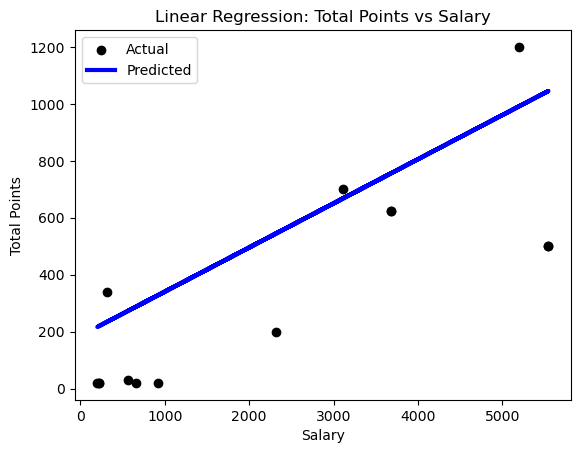

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'combined_output_with_salaries - Copy.csv'
data = pd.read_csv(file_path)

# Define the predictor and response variables
y = data['salary']  # Response variable
X = data[['Total_Points']]  # Predictor variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error and the coefficient of determination (R^2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate the adjusted R^2
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Adjusted R^2 Score: {adjusted_r2}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

# Plot the results
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Predicted')
plt.xlabel('Salary')
plt.ylabel('Total Points')
plt.title('Linear Regression: Total Points vs Salary')
plt.legend()
plt.show()

## b2) Last Three Year Performance Analysis

In [19]:
player_runs_2024 = player_runs[player_runs['Season']=='2024'].sort_values(by='runs_scored',ascending=False)
player_runs_2023 = player_runs[player_runs['Season']=='2023'].sort_values(by='runs_scored',ascending=False)
player_runs_2022 = player_runs[player_runs['Season']=='2022'].sort_values(by='runs_scored',ascending=False)

player_runs_last_three_seasons = pd.concat([player_runs_2024, player_runs_2023, player_runs_2022])
player_runs_last_three_seasons.sort_values(by='runs_scored',ascending=False)

,Season,Striker,runs_scored
2423,2023,Shubman Gill,890
2144,2022,JC Buttler,863
2313,2023,F du Plessis,730
2311,2023,DP Conway,672
2433,2023,V Kohli,639
...,...,...,...
2583,2024,TA Boult,0
2527,2024,Mukesh Kumar,0
2462,2024,Anmolpreet Singh,0
2560,2024,Ravi Bishnoi,0


In [20]:
player_wickets_2024 = player_wickets[player_wickets['Season']=='2024'].sort_values(by='wicket_confirmation',ascending=False)
player_wickets_2023 = player_wickets[player_wickets['Season']=='2023'].sort_values(by='wicket_confirmation',ascending=False)
player_wickets_2022 = player_wickets[player_wickets['Season']=='2022'].sort_values(by='wicket_confirmation',ascending=False)

player_wickets_last_three_seasons = pd.concat([player_wickets_2024, player_wickets_2023, player_wickets_2022])
player_wickets_last_three_seasons.sort_values(by='wicket_confirmation',ascending=False)

,Season,Bowler,wicket_confirmation
1750,2023,MM Sharma,31
1671,2022,YS Chahal,29
1755,2023,Mohammed Shami,28
1782,2023,Rashid Khan,28
1629,2022,PWH de Silva,27
...,...,...,...
1901,2024,S Joseph,0
1874,2024,Mukesh Choudhary,0
1879,2024,Naman Dhir,0
1895,2024,Ramandeep Singh,0


In [21]:
import os
import pandas as pd

os.chdir('/Users/sarathsabu/Desktop/scma/A2/Last Three Years Performance')

# Sort the DataFrame by 'wicket_confirmation' in descending order
sorted_df = player_wickets_last_three_seasons.sort_values(by='wicket_confirmation', ascending=False)
sorted_df1 = player_runs_last_three_seasons.sort_values(by='runs_scored', ascending=False)

# Save the sorted DataFrames to the current working directory
sorted_df.to_csv('sorted_player_wickets.csv', index=False)
sorted_df1.to_csv('sorted_player_runs.csv', index=False)

print("DataFrame sorted and saved to 'sorted_player_wickets.csv'.")
print("DataFrame sorted and saved to 'sorted_player_runs.csv'.")

DataFrame sorted and saved to 'sorted_player_wickets.csv'.
DataFrame sorted and saved to 'sorted_player_runs.csv'.


In [22]:
import os
import pandas as pd

# Change the working directory
os.chdir('/Users/sarathsabu/Desktop/scma/A2/Last Three Years Performance')

# Load the dataset for bowlers
bowler_file_path = 'sorted_player_wickets.csv'  # Replace with your actual file path
bowler_data = pd.read_csv(bowler_file_path)

# Drop the 'Season' column for bowlers
bowler_data.drop(columns=['Season'], inplace=True)

# Aggregate the 'wicket_confirmation' by 'Bowler'
aggregated_bowler_data = bowler_data.groupby('Bowler')['wicket_confirmation'].sum().reset_index()

# Save the aggregated data to a new CSV file for bowlers directly in the specified directory
bowler_output_file_path = 'aggregated_player_wickets.csv'
aggregated_bowler_data.to_csv(bowler_output_file_path, index=False)

print(f"Aggregated bowler data saved to '{bowler_output_file_path}'.")

# Load the dataset for strikers
striker_file_path = 'sorted_player_runs.csv'  # Replace with your actual file path
striker_data = pd.read_csv(striker_file_path)

# Drop the 'Season' column for strikers
striker_data.drop(columns=['Season'], inplace=True)

# Aggregate the 'runs_scored' by 'Striker'
aggregated_striker_data = striker_data.groupby('Striker')['runs_scored'].sum().reset_index()

# Save the aggregated data to a new CSV file for strikers directly in the specified directory
striker_output_file_path = 'aggregated_player_runs.csv'
aggregated_striker_data.to_csv(striker_output_file_path, index=False)

print(f"Aggregated striker data saved to '{striker_output_file_path}'.")


Aggregated bowler data saved to 'aggregated_player_wickets.csv'.
Aggregated striker data saved to 'aggregated_player_runs.csv'.


In [23]:
import os
import pandas as pd

# Define the lcs_score function
def lcs_score(s1, s2):
    n, m = len(s1), len(s2)
    if n == 0 or m == 0:
        return 0.0

    # Calculate LCS length
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if s1[i - 1] == s2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    lcs_length = dp[n][m]

    # Calculate LCS score
    average_length = (n + m) / 2.0
    score = lcs_length / average_length

    return score

# Load the CSV and Excel files
csv_path = 'aggregated_player_runs.csv'
excel_path = 'IPL SALARIES 2024.xlsx'

ball_by_ball_df = pd.read_csv(csv_path)
salaries_df = pd.read_excel(excel_path)

# Process Strikers
player_runs1 = ball_by_ball_df.groupby('Striker')['runs_scored'].sum().to_dict()
striker_names = ball_by_ball_df['Striker'].unique()
player_names = salaries_df['Player'].unique()

striker_matches = []

for striker in striker_names:
    for player in player_names:
        score = lcs_score(striker, player)
        if score > 0.80:
            actual_player_name = max(player_runs1.keys(), key=lambda k: lcs_score(player, k))
            runs_scored = player_runs1.get(actual_player_name, 0)
            striker_matches.append({'Striker': striker, 'Player': player, 'Score': score, 'Runs_Scored': runs_scored})

# Save striker matches to CSV in specified directory
striker_matches_df = pd.DataFrame(striker_matches)
striker_output_dir = r'/Users/sarathsabu/Desktop/scma/A2/Last Three Years Performance'
striker_output_path = os.path.join(striker_output_dir, 'output_striker.csv')
striker_matches_df.to_csv(striker_output_path, index=False)

# Process Bowlers
csv_path1 = 'aggregated_player_wickets.csv'
ball_by_ball_df1 = pd.read_csv(csv_path1)
player_wickets1 = ball_by_ball_df1.groupby('Bowler')['wicket_confirmation'].sum().to_dict()
bowler_names = ball_by_ball_df1['Bowler'].unique()

bowler_matches = []

for bowler in bowler_names:
    for player in player_names:
        score = lcs_score(bowler, player)
        if score > 0.80:
            actual_player_name = max(player_wickets1.keys(), key=lambda k: lcs_score(player, k))
            wickets_confirmation = player_wickets1.get(actual_player_name, 0)
            bowler_matches.append({'Bowler': bowler, 'Player': player, 'Score': score, 'Wicket_Confirmation': wickets_confirmation})

# Save bowler matches to CSV in specified directory
bowler_matches_df = pd.DataFrame(bowler_matches)
bowler_output_path = os.path.join(striker_output_dir, 'output_bowler.csv')
bowler_matches_df.to_csv(bowler_output_path, index=False)

striker_output_path, bowler_output_path

('/Users/sarathsabu/Desktop/scma/A2/Last Three Years Performance/output_striker.csv',
 '/Users/sarathsabu/Desktop/scma/A2/Last Three Years Performance/output_bowler.csv')

In [24]:
import pandas as pd

def calculate_striker_points(input_file: str, output_file: str):
    # Load the CSV file into a DataFrame
    df_striker = pd.read_csv(input_file)
    
    # Calculate Points Scored for each row
    df_striker['Points Scored'] = df_striker['Runs_Scored']
    
    # Save the modified DataFrame back to the CSV file
    df_striker.to_csv(output_file, index=False)
    print(f"Updated {output_file} with Points Scored for strikers.")

def calculate_bowler_points(input_file: str, output_file: str):
    # Load the CSV file into a DataFrame
    df_bowler = pd.read_csv(input_file)
    
    # Calculate Points Scored for each row (assuming 'wicket_confirmation' is the column name for wickets taken)
    df_bowler['Points Scored'] = df_bowler['Wicket_Confirmation'] * 25
    
    # Save the modified DataFrame back to the CSV file
    df_bowler.to_csv(output_file, index=False)
    print(f"Updated {output_file} with Points Scored for bowlers.")

# Example usage:
calculate_striker_points('output_striker.csv', 'output_striker.csv')
calculate_bowler_points('output_bowler.csv', 'output_bowler.csv')


Updated output_striker.csv with Points Scored for strikers.
Updated output_bowler.csv with Points Scored for bowlers.


In [25]:
import os
import pandas as pd

def calculate_striker_points(input_file: str, output_file: str):
    # Change the working directory
    os.chdir('/Users/sarathsabu/Desktop/scma/A2/Last Three Years Performance')
    
    # Load the CSV file into a DataFrame
    df_striker = pd.read_csv(input_file)
    
    # Calculate Points Scored for each row
    df_striker['Points Scored'] = df_striker['Runs_Scored']
    
    # Save the modified DataFrame back to the CSV file in the new folder
    df_striker.to_csv(output_file, index=False)
    print(f"Updated {output_file} with Points Scored for strikers.")

def calculate_bowler_points(input_file: str, output_file: str):
    # Change the working directory
    os.chdir('/Users/sarathsabu/Desktop/scma/A2/Last Three Years Performance')
    
    # Load the CSV file into a DataFrame
    df_bowler = pd.read_csv(input_file)
    
    # Calculate Points Scored for each row (assuming 'Wicket_Confirmation' is the column name for wickets taken)
    df_bowler['Points Scored'] = df_bowler['Wicket_Confirmation'] * 25
    
    # Save the modified DataFrame back to the CSV file in the new folder
    df_bowler.to_csv(output_file, index=False)
    print(f"Updated {output_file} with Points Scored for bowlers.")

# Example usage:
calculate_striker_points('output_striker.csv', 'output_striker.csv')
calculate_bowler_points('output_bowler.csv', 'output_bowler.csv')

Updated output_striker.csv with Points Scored for strikers.
Updated output_bowler.csv with Points Scored for bowlers.


In [26]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'output_striker.csv'
df = pd.read_csv(file_path)

# Rename the 'Player' column to 'Points'
df.rename(columns={'Points Scored': 'Points for Batsman'}, inplace=True)

# Save the modified DataFrame back to the CSV file
df.to_csv(file_path, index=False)

print(f"Renamed 'Points Scored' column to 'Points for Batsman' in '{file_path}'.")

Renamed 'Points Scored' column to 'Points for Batsman' in 'output_striker.csv'.


In [27]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'output_bowler.csv'
df = pd.read_csv(file_path)

# Rename the 'Player' column to 'Points'
df.rename(columns={'Points Scored': 'Points for Bowler'}, inplace=True)

# Save the modified DataFrame back to the CSV file
df.to_csv(file_path, index=False)

print(f"Renamed 'Points Scored' column to 'Points for Bowler' in '{file_path}'.")

Renamed 'Points Scored' column to 'Points for Bowler' in 'output_bowler.csv'.


In [28]:
import pandas as pd

# Load the CSV files
striker_df = pd.read_csv('output_striker.csv')
bowler_df = pd.read_csv('output_bowler.csv')

# Combine the two dataframes on the 'Player' column using an outer join to keep all players
combined_df = pd.merge(striker_df, bowler_df, on='Player', how='outer', suffixes=('_Batsman', '_Bowler'))

# Fill NaN values with 0 for points columns for proper addition
combined_df['Points for Batsman'].fillna(0, inplace=True)
combined_df['Points for Bowler'].fillna(0, inplace=True)

# Iterate through the combined dataframe and calculate total points
for index, row in combined_df.iterrows():
    if pd.notna(row['Points for Batsman']) and pd.notna(row['Points for Bowler']):
        total_points = row['Points for Batsman'] + row['Points for Bowler']
        if row['Points for Batsman'] > 0 and row['Points for Bowler'] > 0:
            print(f"Match found, points for {row['Player']} = {total_points}")
        else:
            print(f"No match found, total points for {row['Player']} = {total_points}")
    else:
        total_points = row['Points for Batsman'] + row['Points_Bowler']
        print(f"No match found, total points for {row['Player']} = {total_points}")

# Optionally, save the combined dataframe to a new CSV
combined_df['Total_Points'] = combined_df['Points for Batsman'] + combined_df['Points for Bowler']
combined_df.to_csv('combined_output.csv', index=False)

Match found, points for Amit Mishra = 219.0
Match found, points for Adam Zampa = 235.0
No match found, total points for Abdul Samad = 321.0
Match found, points for Abhishek Sharma = 1005.0
No match found, total points for Abhishek Porel = 235.0
Match found, points for Akash Deep = 219.0
Match found, points for Akash Madhwal = 554.0
No match found, total points for Anmolpreet Singh = 118.0
No match found, total points for Anuj Rawat = 318.0
Match found, points for Arjun Tendulkar = 113.0
Match found, points for Arshdeep Singh = 1123.0
No match found, total points for Atharva Taide = 201.0
Match found, points for Avesh Khan (T) = 947.0
No match found, total points for B. Sai Sudharsan = 925.0
No match found, total points for Dhruv Jurel = 254.0
No match found, total points for Faf Du Plessis = 1486.0
Match found, points for Fazalhaq Farooqi = 153.0
Match found, points for Harpreet  Brar = 607.0
Match found, points for Harshit Rana = 452.0
No match found, total points for Ishan Kishan = 1

In [29]:
import os
import pandas as pd

# Read the CSV file
combined_output = pd.read_csv('combined_output.csv')

# Read the Excel file
ipl_salaries = pd.read_excel('IPL SALARIES 2024.xlsx')

# Assuming the Excel sheet has columns 'Player' and 'Salary'
# If not, you need to adjust these column names accordingly.
player_salaries = ipl_salaries[['Player', 'Rs']]

# Create a dictionary for quick look-up
salary_dict = dict(zip(player_salaries['Player'], player_salaries['Rs']))

# Initialize the salary column with NaN
combined_output['salary'] = float('nan')

# Compare and update the salary
for index, row in combined_output.iterrows():
    player_name = row['Player']
    if player_name in salary_dict:
        combined_output.at[index, 'salary'] = salary_dict[player_name]
        print(f"Player {player_name} matched with a salary of Rs {salary_dict[player_name]}")

# Change the working directory
os.chdir('/Users/sarathsabu/Desktop/scma/A2/Last Three Years Performance')

# Save the updated DataFrame to a new CSV file directly in the specified directory
output_file_path = 'combined_output_with_salaries.csv'
combined_output.to_csv(output_file_path, index=False)

print(f"Updated DataFrame with salaries saved to '{output_file_path}'.")

Player Amit Mishra matched with a salary of Rs 50
Player Adam Zampa matched with a salary of Rs 150
Player Abdul Samad matched with a salary of Rs 400
Player Abhishek Sharma matched with a salary of Rs 650
Player Abhishek Porel matched with a salary of Rs 20
Player Akash Deep matched with a salary of Rs 20
Player Akash Madhwal matched with a salary of Rs 20
Player Anmolpreet Singh matched with a salary of Rs 20
Player Anuj Rawat matched with a salary of Rs 340
Player Arjun Tendulkar matched with a salary of Rs 30
Player Arshdeep Singh matched with a salary of Rs 400
Player Atharva Taide matched with a salary of Rs 20
Player Avesh Khan (T) matched with a salary of Rs 1000
Player B. Sai Sudharsan matched with a salary of Rs 20
Player Dhruv Jurel matched with a salary of Rs 20
Player Faf Du Plessis matched with a salary of Rs 700
Player Fazalhaq Farooqi matched with a salary of Rs 50
Player Harpreet  Brar matched with a salary of Rs 380
Player Harshit Rana matched with a salary of Rs 20
P

In [30]:
import os
import pandas as pd

# Define the file paths
input_file = 'combined_output_with_salaries.csv'
output_file = 'combined_output_with_salaries - Copy.csv'

# Columns to keep
columns_to_keep = ['Player', 'Total_Points', 'salary']

# Read the CSV file into a DataFrame
df = pd.read_csv(input_file)

# Keep only the specified columns
df_filtered = df[columns_to_keep]

# Save the filtered DataFrame to a new CSV file in the current working directory
df_filtered.to_csv(output_file, index=False)

print(f"Filtered data saved to '{output_file}'.")



Filtered data saved to 'combined_output_with_salaries - Copy.csv'.


Mean Squared Error: 140765.77405307363
R^2 Score: 0.17755432134588423
Adjusted R^2 Score: 0.10901718145804118
Coefficients: [0.64452508]
Intercept: -16.806266954795376


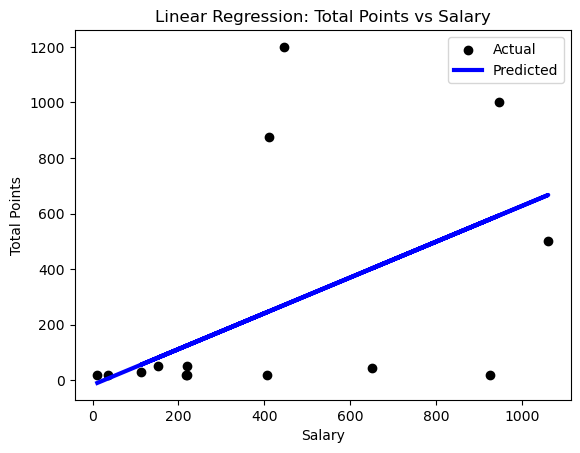

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'combined_output_with_salaries - Copy.csv'
data = pd.read_csv(file_path)

# Define the predictor and response variables
y = data['salary']  # Response variable
X = data[['Total_Points']]  # Predictor variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error and the coefficient of determination (R^2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate the adjusted R^2
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Adjusted R^2 Score: {adjusted_r2}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

# Plot the results
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Predicted')
plt.xlabel('Salary')
plt.ylabel('Total Points')
plt.title('Linear Regression: Total Points vs Salary')
plt.legend()
plt.show()